In [34]:
def create_md_of_notebook():
    !jupyter nbconvert ./classify_mnist_additional_exercises.ipynb --to markdown

create_md_of_notebook()

[NbConvertApp] Converting notebook ./classify_mnist_additional_exercises.ipynb to markdown
[NbConvertApp] Support files will be in classify_mnist_additional_exercises_files/
[NbConvertApp] Making directory ./classify_mnist_additional_exercises_files
[NbConvertApp] Writing 10456 bytes to classify_mnist_additional_exercises.md


# Classifying the MNIST dataset -  Additional Exercises

Note that this is taken from Chapter 3 of the Hand-on Machine Learning book.

It is recommended you review my **Classifying the MNIST dataset - Hello, World** article to get a background on the MNIST dataset

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

sklearn.__version__

'1.1.1'

Get the dataset

In [20]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist['data'].to_csv('./mnist_data.csv')
mnist['target'].to_csv('./mnist_target.csv')
mnist.keys()

# mnist = dict()
# mnist['data'] = pd.read_csv('./mnist_data.csv', index_col=0)
# mnist['target'] = pd.read_csv('./mnist_target.csv', index_col=0).squeeze('columns')

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Convert the target to a number, and split the dataset into a train and test set

In [21]:
X, y = mnist["data"].to_numpy(), mnist["target"].to_numpy()
y = y.astype(np.uint8)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## The Task - 97% Accuracy Classifier

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the `KNeighborsClassifier` works quite well for this task; you just need to find good hyperparameter values (try a grid search on the `weights` and `n_neighbors` hyperparameters).

Let's build a `KNeighborsClassifier` model using `GridSearchCV` to find the best parameters.

***NOTE that this cell make take 16+ hours to run***

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

What were our best parameters?

In [23]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

What was our best score?

In [24]:
grid_search.best_score_

0.9716166666666666

Looks promising. Now lets run the best model on the test set

In [25]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

Looks like we achieved 97%!

## The Task - Data Augmentation

Write a function that can shift the MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now. This technique of artifically growing the training set is called _data augmentation_ or _training set expansion_.

We can use scipy's `shift` function the shift the image

In [26]:
from scipy.ndimage import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

Let's run a quick example by shifting a single image 5 pixels down and 5 pixels left.

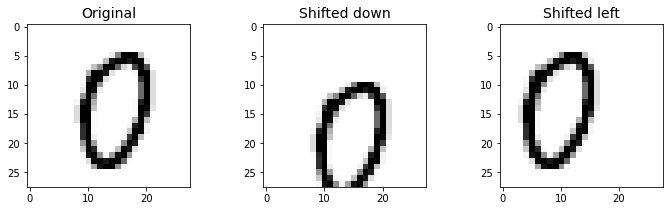

In [27]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

Those look good. Lets create the augmented dataset by adding an image shifted up, left, down and right.

In [28]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

We should make sure we shuffle the dataset to make sure the images that were generated from the original are not all next to each other

In [29]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

Now let's create a new `KNeighborsClassifier` and train it with the augmented data:

In [30]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

Finally, let's test our classifier trained with the augmented data on the test set to see what our accuracy score is.

***NOTE that this cell may take up to an hour to run***

In [31]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

By simply augmenting the data, we got roughly a 0.5% accuracy boost!